## KQ3: Pritts Meta-analysis Update

In key question 3, we address the risk of sarcoma dissemination following morcellation of fibroids. We identified a recently published analysis conducted by Elizabeth Pritts and her colleagues (2015) to estimate the  prevalence of occult leiomyosarcoma at time of treatment for presumed benign tumors (fibroids).  We updated their search and used similar eligibility criteria to identify papers published since 2014. We extracted from these papers the number of women who were treated for uterine fibroids and the cases of leiomyosarcoma subsequently identified.  We have combined these data with the data from the 134 publications that Pritts et al included in their analysis for a total of LMS rates from 148 sources.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

In [2]:
kq3_data = pd.read_excel('data/UF CER KQ3 Data for Analysis.xlsx', sheetname='5.UFKQ3Data', 
                         na_values=['NR', 'NA'],
                        index_col=0)[['Author', 'Year', 'Design', 'Procedure', 'Indication',
                                     'Age, Mean', 'Age, SD', 'Age, Median', 'Age, Min', 'Age, Max', 'Age, Other',
                                     'LMS','Population','Tumors','InPritts']].dropna(thresh=7)
kq3_data.head()

,Author,Year,Design,Procedure,Indication,"Age, Mean","Age, SD","Age, Median","Age, Min","Age, Max","Age, Other",LMS,Population,Tumors,InPritts
Line,,,,,,,,,,,,,,,
1.0,"Adelusola KA, Ogunniyi SO",2001,Retrospective,NE,NE,NaN,NaN,NaN,19.0,89,NaN,0.0,177.0,0.0,1.0
2.0,"Ahmed AA, Stachurski J, Abdel Aziz E et al",2002,Prospective,NE,NE,NaN,NaN,NaN,29.0,65,NaN,0.0,10.0,0.0,1.0
3.0,"Angle HS, Cohen SM, Hidlebaugh D",1995,Retrospective,NE,NE,41.0,NaN,NaN,24.0,81,NaN,0.0,41.0,0.0,1.0
4.0,"Banaczek Z, Sikora K, Lewandowska-Andruszuk I",2004,Retrospective,NE,NE,44.5,NaN,NaN,29.0,73,NaN,0.0,309.0,0.0,1.0
5.0,"Barbieri R, Dilena M, Chumas J, Rein MS, Fried...",1993,RCT,NE,NE,33.7,NaN,NaN,NaN,NaN,36.3,0.0,20.0,0.0,1.0


Missing values

In [3]:
kq3_data.isnull().sum()

Author           0
Year             0
Design           0
Procedure        0
Indication       2
Age, Mean       67
Age, SD        138
Age, Median    142
Age, Min        58
Age, Max        59
Age, Other     114
LMS              0
Population       0
Tumors           0
InPritts         0
dtype: int64

In [4]:
kq3_data['age_max'] = kq3_data['Age, Max'].replace('50+', 50)
kq3_data = kq3_data.rename(columns={'Age, Min': 'age_min',
                                   'Age, Mean': 'age_mean',
                                   'Age, SD': 'age_sd',
                                   'Age, Median': 'age_med'})

In [5]:
kq3_data.describe()

,age_mean,age_sd,age_med,age_min,LMS,Population,Tumors,InPritts,age_max
count,81.000000,10.000000,6.000000,90.000000,148.000000,148.000000,148.000000,148.000000,89.000000
mean,41.744815,7.071000,39.833333,26.860000,1.750000,790.472973,1.750000,0.905405,61.638202
std,6.269069,3.044779,4.910261,6.393638,14.256577,3299.459447,14.256577,0.293648,13.414371
min,28.200000,1.800000,35.000000,18.000000,0.000000,5.000000,0.000000,0.000000,34.000000
25%,37.200000,6.025000,36.475000,21.250000,0.000000,40.000000,0.000000,1.000000,51.000000
50%,41.900000,6.600000,38.200000,25.000000,0.000000,90.500000,0.000000,1.000000,60.000000
75%,45.900000,7.812500,42.700000,31.000000,0.000000,297.750000,0.000000,1.000000,71.000000
max,61.200000,12.300000,47.500000,44.000000,172.000000,34603.000000,172.000000,1.000000,96.000000


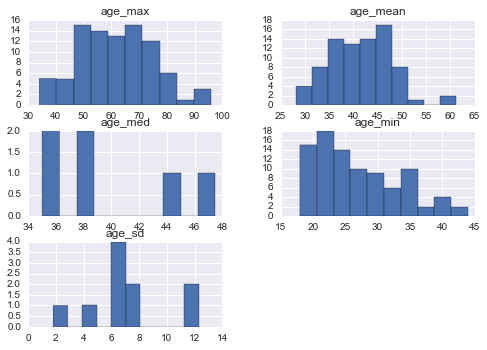

In [6]:
kq3_data[[c for c in kq3_data.columns if c.startswith('age')]].hist();

Breakdown on studies by design.

In [7]:
kq3_data.Design.value_counts()

Retrospective       83
Prospective         38
RCT                 26
Pop based cohort     1
Name: Design, dtype: int64

I will drop the cohort study, since it is the only such representative.

In [8]:
kq3_data = kq3_data[kq3_data.Design!='Pop based cohort']

In [9]:
kq3_data = pd.concat([kq3_data, pd.get_dummies(kq3_data.Design)[['Prospective', 'RCT']]], axis=1)

Following [Pritts et al. (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26283890), I fit a binomial random effects model, such that event probabilities on the logit scale are normally distributed with mean $\mu$ and standard deviation $\sigma$. This distribution describes how the probabilities vary across studies, with the degree of variation described by $\sigma$.

$$\theta_i \sim N(\mu, \sigma^2)$$

the expected value for study $i$ is then inverse-logit transformed, and used as the event probability $\pi_i$ in a binomial model describing the number of observed tumors $t$:

$$\log\left[\frac{\pi_i}{1-\pi_i}\right] = \theta_i$$

$$t_i \sim \text{Bin}(n_i, \pi_i)$$

In [10]:
import theano.tensor as tt
from numpy.ma import masked_values

model_data = kq3_data

k = model_data.shape[0]
tumors = model_data.Tumors.values.astype(int)
n = model_data.Population.values.astype(int)
X = model_data[['Prospective', 'RCT']].values.astype(int)
age_max_norm = ((model_data.age_max - 60)/10).fillna(0.5).values

poly_terms = 3

def invlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

In [11]:
with pm.Model() as pritts_update:
    
    # Impute missing max ages
    age_max_missing = masked_values(age_max_norm, value=0.5)
    ν = pm.HalfCauchy('ν', 5, testval=1)
    μ_age = pm.Normal('μ_age', 0, 5, testval=0)
    age_max = pm.StudentT('age_max', ν, mu=μ_age, observed=age_max_missing)
    
    # Study random effect
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    # Design effects
    β = pm.Normal('β', 0, sd=10, shape=2, testval=np.zeros(2))
    # Polynomial age effect with Lasso
    α = pm.Normal('α', 0, sd=10, testval=0)
    
    # Study-specific probabilities
    π = pm.Deterministic('π', invlogit(θ + tt.dot(X,β) + α*age_max))
    
    # Expected probabilities by design
    p_retro_1000 = pm.Deterministic('p_retro_1000', invlogit(μ)*1000)
    p_prosp_1000 = pm.Deterministic('p_prosp_1000', invlogit(μ + β[0])*1000)
    p_rct_1000 = pm.Deterministic('p_rct_1000', invlogit(μ + β[1])*1000)
    
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)

Applied log-transform to ν and added transformed ν_log to model.
Applied interval-transform to σ and added transformed σ_interval to model.


In [19]:
with pritts_update:
    step = pm.NUTS()
    trace = pm.sample(2000, step=step, njobs=2, random_seed=[20140425, 19700903])

 [-----------------100%-----------------] 2001 of 2000 complete in 689.1 sec

In [ ]:
from theano.tensor.nlinalg import matrix_inverse
from theano import shared

with pm.Model() as pritts_gp:
    
    # Impute missing max ages
    age_max_missing = masked_values(age_max_norm, value=0.5)
    ν = pm.HalfCauchy('ν', 5, testval=1)
    μ_age = pm.Normal('μ_age', 0, 5, testval=0)
    age_max = pm.StudentT('age_max', ν, mu=μ_age, observed=age_max_missing)
    
    # Study random effect
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    # Design effects
    β = pm.Normal('β', 0, sd=10, shape=2, testval=np.zeros(2))
    
    # Gaussian process age effect
    η_sq = pm.HalfCauchy('η_sq', 5, testval=1)
    ρ_sq = pm.HalfCauchy('ρ_sq', 5, testval=1)
    σ_sq = pm.HalfCauchy('σ_sq', 5, testval=1)
    
    # Mean function is linear model
    α = pm.Normal('α', 0, sd=10, testval=0)
    
    D = (age_max[None, :] - age_max[:, None])**2
    
    # Squared exponential
    Σ = tt.fill_diagonal(η_sq * tt.exp(-ρ_sq * D), η_sq + σ_sq)
    
    age_effect = pm.MvNormal('age_effect', α*age_max, matrix_inverse(Σ), shape=k)
    
    
    # Study-specific probabilities
    π = pm.Deterministic('π', invlogit(θ + tt.dot(X,β) + age_effect))
    
    # Expected probabilities by design
    p_retro_1000 = pm.Deterministic('p_retro_1000', invlogit(μ)*1000)
    p_prosp_1000 = pm.Deterministic('p_prosp_1000', invlogit(μ + β[0])*1000)
    p_rct_1000 = pm.Deterministic('p_rct_1000', invlogit(μ + β[1])*1000)
    
    # Data likelihood
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)
    
    
    # Age effect prediction across age range
    age_pred = shared(np.linspace(-3, 3))
    
    D_pred = (age_pred[None, :] - age_pred[:, None])**2
    D_off_diag = (age_max[None, :] - age_pred[:, None])**2
    
    # Covariance matrices for prediction
    Σ_pred = η_sq * tt.exp(-ρ_sq * D_pred)
    Σ_off_diag = η_sq * tt.exp(-ρ_sq * D_off_diag)
    
    # Posterior mean
    μ_post = pm.Deterministic('μ_post', tt.dot(tt.dot(Σ_off_diag, matrix_inverse(Σ)), age_effect))
    # Posterior covariance
    Σ_post = pm.Deterministic('Σ_post', Σ_pred - tt.dot(tt.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T))


Applied log-transform to ν and added transformed ν_log to model.
Applied interval-transform to σ and added transformed σ_interval to model.
Applied log-transform to η_sq and added transformed η_sq_log to model.
Applied log-transform to ρ_sq and added transformed ρ_sq_log to model.
Applied log-transform to σ_sq and added transformed σ_sq_log to model.


In [ ]:
with pritts_gp:
#     trace_gp = pm.sample(2000, random_seed=[20140425, 19700903])
    gp_fit = pm.variational.advi(n=10000)

Iteration 0 [0%]: ELBO = -4107.65
Iteration 1000 [10%]: ELBO = -6577.65
Iteration 2000 [20%]: ELBO = -1944.18
Iteration 3000 [30%]: ELBO = -1756.02
Iteration 4000 [40%]: ELBO = -1868.21
Iteration 5000 [50%]: ELBO = -846.25
Iteration 6000 [60%]: ELBO = -552.44
Iteration 7000 [70%]: ELBO = -388.12
Iteration 8000 [80%]: ELBO = -340.14
Iteration 9000 [90%]: ELBO = -371.07
Finished [100%]: ELBO = -334.94
> /Users/fonnescj/Repositories/pymc3/pymc3/variational/advi.py(92)advi()
-> u = bij.rmap(result[:l])
(Pdb) result
array([-1.57394472, -1.07141382, -1.3582619 , -1.68152459, -1.10041214,
       -1.2048846 , -1.15309063, -1.76189649, -1.03066107, -1.12850817,
       -1.49112543, -1.41387602, -1.12868796, -1.16701597, -1.01527639,
       -1.37230737, -0.84559676, -1.07953759, -1.14990164, -1.27973206,
       -1.07484227, -1.18570376, -1.20922203, -1.50451355, -1.19601986,
       -1.35911403, -1.15136802, -1.12950555, -1.09675957, -1.14508474,
       -0.85203796, -1.75225433, -1.8314474 , -1.23

(Pdb) n
> /Users/fonnescj/Repositories/pymc3/pymc3/variational/advi.py(93)advi()
-> w = bij.rmap(result[l:])
(Pdb) n
> /Users/fonnescj/Repositories/pymc3/pymc3/variational/advi.py(95)advi()
-> for var in w.keys():


In [27]:
gp_fit[0].keys()

dict_keys(['age_max_missing', 'ρ_sq_log', 'μ', 'β', 'ν_log', 'σ_interval', 'α', 'μ_age', 'σ_sq_log', 'θ', 'η_sq_log', 'age_effect'])

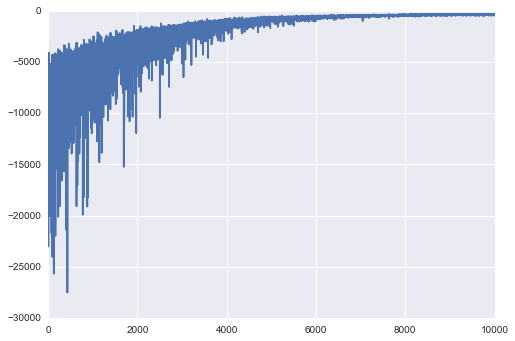

In [25]:
plt.plot(gp_fit[2])

In [26]:
gp_fit[0]['μ']

array(-4.247524017326264)

The following plots are the distribution of samples from the posterior distributions for the expected (population) probability of tumor (`p_update`), the inverse-logit expected probability ($\mu$) and the standard deviation of the probabilities on the inverse-logit scale ($\sigma$).

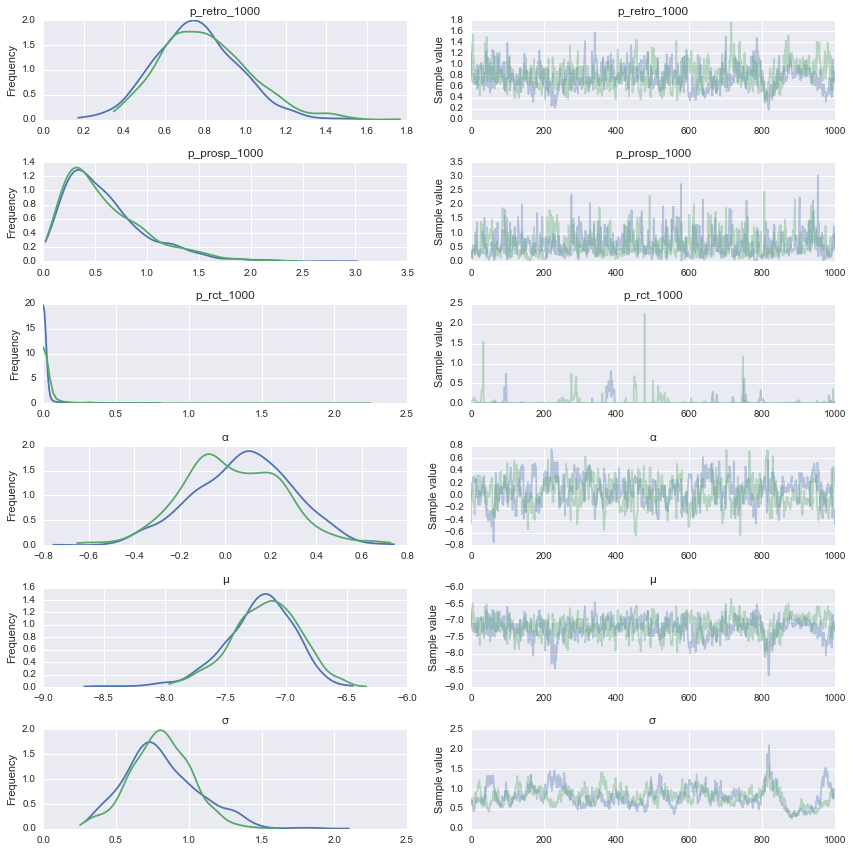

In [20]:
pm.traceplot(trace[1000:], varnames=['p_retro_1000', 'p_prosp_1000', 'p_rct_1000', 'α', 'μ', 'σ']);

Summary statistics from each of the above parameters.

In [19]:
pm.summary(trace[1000:], varnames=['p_retro_1000', 'p_prosp_1000', 'p_rct_1000', 'μ', 'σ'], roundto=4)


p_retro_1000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.7946           0.1931           0.0113           [0.4376, 1.1639]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.4451         0.6585         0.7891         0.9241         1.1779


p_prosp_1000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.5657           0.4015           0.0174           [0.0169, 1.3539]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.0746         0.2845         0.4725         0.7486         1.5540


p_rct_1000:

  Mean             SD               MC Error         95% HPD interval
  

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


By comparison, estimates from Pritts' supplement:

![pritts estimates](pritts_table.png)

In [58]:
p_vars = ['p_retro_1000', 'p_prosp_1000', 'p_rct_1000']
intervals = [pm.stats.hpd(trace[var]) for var in p_vars]

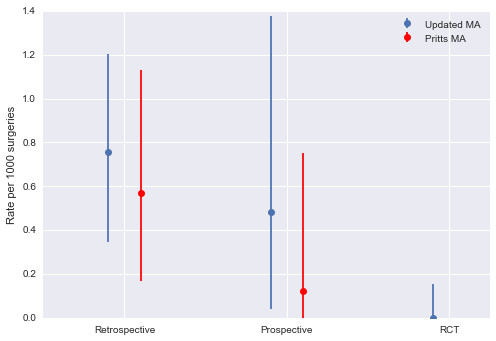

In [66]:
meds = [np.median(trace[var]) for var in p_vars]
upper = [i[1] - m for m,i in zip(meds, intervals)]
lower = [m - i[0] for m,i in zip(meds, intervals)]

plt.errorbar(np.arange(3)-0.1, meds, yerr=[lower, upper], fmt='o', label='Updated MA')
plt.errorbar(np.arange(2)+0.1, [0.57, 0.12], yerr=[[0.57-0.17, 0.12], [1.13 - 0.57,0.75 - 0.12]], color='r', fmt='o', label='Pritts MA')
plt.xticks(range(3), ['Retrospective', 'Prospective', 'RCT'])
plt.ylabel('Rate per 1000 surgeries')
plt.xlim(-0.5, 2.25)
plt.legend();

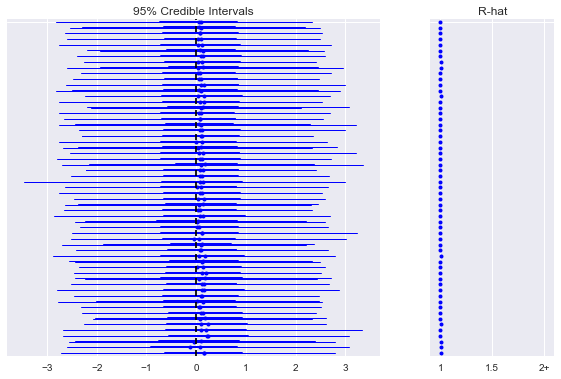

In [21]:
pm.forestplot(trace[1000:], varnames=['age_max_missing'], ylabels=[''])

### Goodness of fit

To check how well the model fits the data, I conducted posteior predictive checks. This simulates data from the model for each data point (*i.e.* study) in the meta-analysis, and compares the distribution of these simulated values (here, 500 replicates) with the value of the data itself. If the percentile of the datum is very extreme (either large or small), then it is evidence that the model does not adequately fit the data. The distribution of percentiles in the bottom histogram shows that there is no evidence of lack of fit.

In [22]:
ppc = pm.sample_ppc(trace, model=pritts_update, samples=500)

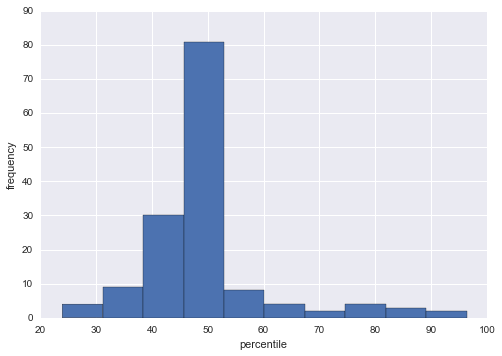

In [23]:
from scipy.stats import percentileofscore
        
p = [percentileofscore(s, o).round(2) for s,o in zip(ppc['obs'].T, tumors)]
        
plt.hist(p)
plt.xlabel('percentile')
plt.ylabel('frequency');